In [35]:
import pandas as pd
import numpy as np
from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display
from sklearn import metrics
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

# 1) Data import

step นี้ต้องไปโหลดข้อมูลจาก https://www.kaggle.com/c/bluebook-for-bulldozers และสร้าง directory ของตัวเองนะครับ

In [2]:
PATH = "/Users/witchapong/Desktop/Datawiz/Bulldozers/"

In [3]:
!ls {PATH}

Data%20Dictionary.xlsx           TrainAndValid.zip
Machine_Appendix.csv             Valid.7z
Test.csv                         Valid.csv
Train.7z                         Valid.zip
Train.csv                        ValidSolution.csv
Train.zip                        median_benchmark.csv
TrainAndValid.7z                 random_forest_benchmark_test.csv
TrainAndValid.csv


In [6]:
df_raw = pd.read_csv(f'{PATH}Train.csv', low_memory=False, 
                     parse_dates=["saledate"])

# 2) ดูข้อมูลคร่าวๆ

In [7]:
def display_all(df):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000): 
        return display(df)

In [8]:
display_all(df_raw.tail().T)

,401120,401121,401122,401123,401124
SalesID,6333336,6333337,6333338,6333341,6333342
SalePrice,10500,11000,11500,9000,7750
MachineID,1840702,1830472,1887659,1903570,1926965
ModelID,21439,21439,21439,21435,21435
datasource,149,149,149,149,149
auctioneerID,1,1,1,2,2
YearMade,2005,2005,2005,2005,2005
MachineHoursCurrentMeter,NaN,NaN,NaN,NaN,NaN
UsageBand,NaN,NaN,NaN,NaN,NaN
saledate,2011-11-02 00:00:00,2011-11-02 00:00:00,2011-11-02 00:00:00,2011-10-25 00:00:00,2011-10-25 00:00:00


# 3) Transform target variable ตามโจทย์ Kaggle

In [9]:
df_raw.SalePrice = np.log(df_raw.SalePrice)

# 4) Extract feature จาก datetime

In [13]:
import re
def add_datepart(df, fldname, drop=True, time=False):

    fld = df[fldname]
    fld_dtype = fld.dtype
    if isinstance(fld_dtype, pd.core.dtypes.dtypes.DatetimeTZDtype):
        fld_dtype = np.datetime64

    if not np.issubdtype(fld_dtype, np.datetime64):
        df[fldname] = fld = pd.to_datetime(fld, infer_datetime_format=True)
    targ_pre = re.sub('[Dd]ate$', '', fldname)
    attr = ['Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear',
            'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start']
    if time: attr = attr + ['Hour', 'Minute', 'Second']
    for n in attr: df[targ_pre + n] = getattr(fld.dt, n.lower())
    df[targ_pre + 'Elapsed'] = fld.astype(np.int64) // 10 ** 9
    if drop: df.drop(fldname, axis=1, inplace=True)

In [14]:
print('#columns before adding date part:',len(df_raw.columns))
add_datepart(df_raw, 'saledate')
print('#columns after adding date part:',len(df_raw.columns))

#columns before adding date part: 53
#columns after adding date part: 65


In [15]:
display_all(df_raw.tail().T)

,401120,401121,401122,401123,401124
SalesID,6333336,6333337,6333338,6333341,6333342
SalePrice,9.25913,9.30565,9.3501,9.10498,8.95545
MachineID,1840702,1830472,1887659,1903570,1926965
ModelID,21439,21439,21439,21435,21435
datasource,149,149,149,149,149
auctioneerID,1,1,1,2,2
YearMade,2005,2005,2005,2005,2005
MachineHoursCurrentMeter,NaN,NaN,NaN,NaN,NaN
UsageBand,NaN,NaN,NaN,NaN,NaN
fiModelDesc,35NX2,35NX2,35NX2,30NX,30NX


# 5) จัดการกับข้อมูลประเภท categorical

In [19]:
from pandas.core.dtypes.common import is_string_dtype
def train_cats(df):
    for n,c in df.items():
        if is_string_dtype(c): df[n] = c.astype('category').cat.as_ordered()

In [22]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 401125 entries, 0 to 401124
Data columns (total 65 columns):
SalesID                     401125 non-null int64
SalePrice                   401125 non-null float64
MachineID                   401125 non-null int64
ModelID                     401125 non-null int64
datasource                  401125 non-null int64
auctioneerID                380989 non-null float64
YearMade                    401125 non-null int64
MachineHoursCurrentMeter    142765 non-null float64
UsageBand                   69639 non-null object
fiModelDesc                 401125 non-null object
fiBaseModel                 401125 non-null object
fiSecondaryDesc             263934 non-null object
fiModelSeries               56908 non-null object
fiModelDescriptor           71919 non-null object
ProductSize                 190350 non-null object
fiProductClassDesc          401125 non-null object
state                       401125 non-null object
ProductGroup               

In [23]:
train_cats(df_raw)

In [24]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 401125 entries, 0 to 401124
Data columns (total 65 columns):
SalesID                     401125 non-null int64
SalePrice                   401125 non-null float64
MachineID                   401125 non-null int64
ModelID                     401125 non-null int64
datasource                  401125 non-null int64
auctioneerID                380989 non-null float64
YearMade                    401125 non-null int64
MachineHoursCurrentMeter    142765 non-null float64
UsageBand                   69639 non-null category
fiModelDesc                 401125 non-null category
fiBaseModel                 401125 non-null category
fiSecondaryDesc             263934 non-null category
fiModelSeries               56908 non-null category
fiModelDescriptor           71919 non-null category
ProductSize                 190350 non-null category
fiProductClassDesc          401125 non-null category
state                       401125 non-null category
ProductGr

# 6) จัดการกับ missing value

In [26]:
display_all(df_raw.isnull().sum().sort_index()/len(df_raw))

Backhoe_Mounting            0.803872
Blade_Extension             0.937129
Blade_Type                  0.800977
Blade_Width                 0.937129
Coupler                     0.466620
Coupler_System              0.891660
Differential_Type           0.826959
Drive_System                0.739829
Enclosure                   0.000810
Enclosure_Type              0.937129
Engine_Horsepower           0.937129
Forks                       0.521154
Grouser_Tracks              0.891899
Grouser_Type                0.752813
Hydraulics                  0.200823
Hydraulics_Flow             0.891899
MachineHoursCurrentMeter    0.644089
MachineID                   0.000000
ModelID                     0.000000
Pad_Type                    0.802720
Pattern_Changer             0.752651
ProductGroup                0.000000
ProductGroupDesc            0.000000
ProductSize                 0.525460
Pushblock                   0.937129
Ride_Control                0.629527
Ripper                      0.740388
S

In [29]:
from pandas.core.dtypes.common import is_numeric_dtype

def get_sample(df,n):
    idxs = sorted(np.random.permutation(len(df))[:n])
    return df.iloc[idxs].copy()

def fix_missing(df, col, name, na_dict):
    if is_numeric_dtype(col):
        if pd.isnull(col).sum() or (name in na_dict):
            df[name+'_na'] = pd.isnull(col)
            filler = na_dict[name] if name in na_dict else col.median()
            df[name] = col.fillna(filler)
            na_dict[name] = filler
    return na_dict

def numericalize(df, col, name, max_n_cat):
    if not is_numeric_dtype(col) and ( max_n_cat is None or len(col.cat.categories)>max_n_cat):
        df[name] = col.cat.codes+1
        
def proc_df(df, y_fld=None, skip_flds=None, ignore_flds=None, do_scale=False, na_dict=None,
            preproc_fn=None, max_n_cat=None, subset=None, mapper=None):
    if not ignore_flds: ignore_flds=[]
    if not skip_flds: skip_flds=[]
    if subset: df = get_sample(df,subset)
    else: df = df.copy()
    ignored_flds = df.loc[:, ignore_flds]
    df.drop(ignore_flds, axis=1, inplace=True)
    if preproc_fn: preproc_fn(df)
    if y_fld is None: y = None
    else:
        if not is_numeric_dtype(df[y_fld]): df[y_fld] = df[y_fld].cat.codes
        y = df[y_fld].values
        skip_flds += [y_fld]
    df.drop(skip_flds, axis=1, inplace=True)
    if na_dict is None: na_dict = {}
    else: na_dict = na_dict.copy()
    na_dict_initial = na_dict.copy()
    for n,c in df.items(): na_dict = fix_missing(df, c, n, na_dict)
    if len(na_dict_initial.keys()) > 0:
        df.drop([a + '_na' for a in list(set(na_dict.keys()) - set(na_dict_initial.keys()))], axis=1, inplace=True)
    if do_scale: mapper = scale_vars(df, mapper)
    for n,c in df.items(): numericalize(df, c, n, max_n_cat)
    df = pd.get_dummies(df, dummy_na=True)
    df = pd.concat([ignored_flds, df], axis=1)
    res = [df, y, na_dict]
    if do_scale: res = res + [mapper]
    return res

In [30]:
df, y, nas = proc_df(df_raw, 'SalePrice')

In [32]:
display_all(df.isnull().sum().sort_index()/len(df))

Backhoe_Mounting               0.0
Blade_Extension                0.0
Blade_Type                     0.0
Blade_Width                    0.0
Coupler                        0.0
Coupler_System                 0.0
Differential_Type              0.0
Drive_System                   0.0
Enclosure                      0.0
Enclosure_Type                 0.0
Engine_Horsepower              0.0
Forks                          0.0
Grouser_Tracks                 0.0
Grouser_Type                   0.0
Hydraulics                     0.0
Hydraulics_Flow                0.0
MachineHoursCurrentMeter       0.0
MachineHoursCurrentMeter_na    0.0
MachineID                      0.0
ModelID                        0.0
Pad_Type                       0.0
Pattern_Changer                0.0
ProductGroup                   0.0
ProductGroupDesc               0.0
ProductSize                    0.0
Pushblock                      0.0
Ride_Control                   0.0
Ripper                         0.0
SalesID             

# 7) Train & validation split

In [33]:
def split_vals(a,n): return a[:n].copy(), a[n:].copy()

n_valid = 12000  # same as Kaggle's test set size
n_trn = len(df)-n_valid
raw_train, raw_valid = split_vals(df_raw, n_trn)
X_train, X_valid = split_vals(df, n_trn)
y_train, y_valid = split_vals(y, n_trn)

X_train.shape, y_train.shape, X_valid.shape

((389125, 66), (389125,), (12000, 66))

# 8) Base model & varying number of trees

In [34]:
import math

def rmse(x,y): return math.sqrt(((x-y)**2).mean())

def print_score(m):
    res = [rmse(m.predict(X_train), y_train), rmse(m.predict(X_valid), y_valid),
                m.score(X_train, y_train), m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

In [36]:
m = RandomForestRegressor(n_jobs=-1)
%time m.fit(X_train, y_train)
print_score(m)

CPU times: user 1min 29s, sys: 1.52 s, total: 1min 30s
Wall time: 39.5 s
[0.09027214982699475, 0.2527352777662978, 0.9829689118549492, 0.885927828932811]


In [37]:
preds = np.stack([t.predict(X_valid) for t in m.estimators_])
preds[:,0], np.mean(preds[:,0]), y_valid[0]

(array([9.04782144, 9.21034037, 9.43348392, 9.10497986, 9.21034037,
        9.25913054, 9.10497986, 8.98719682, 9.21034037, 8.93590353]),
 9.15045170774161,
 9.104979856318357)

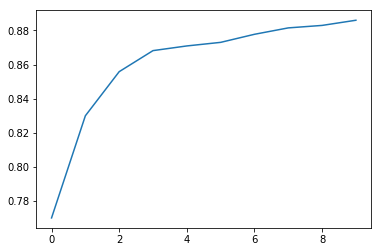

In [40]:
plt.plot([metrics.r2_score(y_valid, np.mean(preds[:i+1], axis=0)) for i in range(10)]);

# 9) Hyper-parameters tuning ง่ายๆ

In [41]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5,\
                          n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.11913184081802052, 0.2266163510714385, 0.9703386761157419, 0.9082870931469655, 0.9118185079711043]
